## Traveling Salesperson Problem with QUBO

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import networkx as nx

,x,y
0,0,0
1,18,57
2,8,75
3,73,59
4,44,22
5,56,7
6,13,69
7,87,83
8,4,70
9,25,90


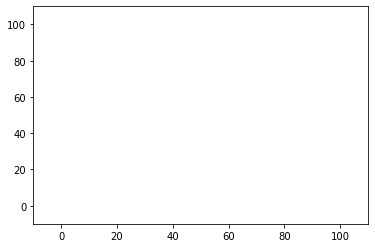

In [18]:
n_point=10
np.random.seed(2002)

df=pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
})


df.iloc[0]['x']=0
df.iloc[0]['y']=0

plt.xlim([-10, 110])
plt.ylim([-10, 110])

df

       x     y
0   6734  1453
1   2233    10
2   5530  1424
3    401   841
4   3082  1644
5   7608  4458
6   7573  3716
7   7265  1268
8   6898  1885
9   1112  2049
10  5468  2606
11  5989  2873
12  4706  2674
13  4612  2035
14  6347  2683
15  6107   669
16  7611  5184
17  7462  3590
18  7732  4723
19  5900  3561
20  4483  3369
21  6101  1110
22  5199  2182
23  1633  2809
24  4307  2322
25   675  1006
26  7555  4819
27  7541  3981
28  3177   756
29  7352  4506
30  7545  2801
31  3245  3305
32  6426  3173
33  4608  1198
34    23  2216
35  7248  3779
36  7762  4595
37  7392  2244
38  3484  2829
39  6271  2135
40  4985   140
41  1916  1569
42  7280  4899
43  7509  3239
44    10  2676
45  6807  2993
46  5185  3258
47  3023  1942


(-111.0, 5432.0)

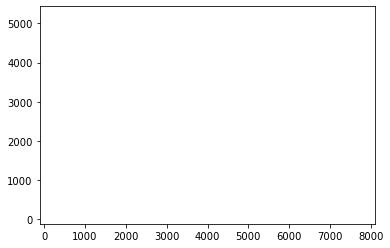

In [19]:
# http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/
with open('att48.txt', 'r') as file: lines=file.readlines()

x_coor=[]
y_coor=[]

for i in lines:
    x, y=map(int, i.strip().split())
    x_coor.append(x)
    y_coor.append(y)

data={'x': x_coor, 'y': y_coor}
df=pd.DataFrame(data)

print(df)

plt.xlim([-111, 8088])
plt.ylim([-111, 5432])


In [20]:
from scipy.spatial import distance_matrix
n_point=len(df)
time_step=n_point

d=distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values, p=2)  # 1=manhattan distance, 2=euclidean distance
print(d)

[[   0.         4726.65314996 1204.34920185 ... 1541.72922396
  2378.53442271 3743.0792137 ]
 [4726.65314996    0.         3587.42316991 ... 5460.74765943
  4389.05547926 2087.27669464]
 [1204.34920185 3587.42316991    0.         ... 2022.99036083
  1866.16746301 2559.95566368]
 ...
 [1541.72922396 5460.74765943 2022.99036083 ...    0.
  1643.50509582 3927.24547234]
 [2378.53442271 4389.05547926 1866.16746301 ... 1643.50509582
     0.         2531.02745935]
 [3743.0792137  2087.27669464 2559.95566368 ... 3927.24547234
  2531.02745935    0.        ]]


Draw problem state

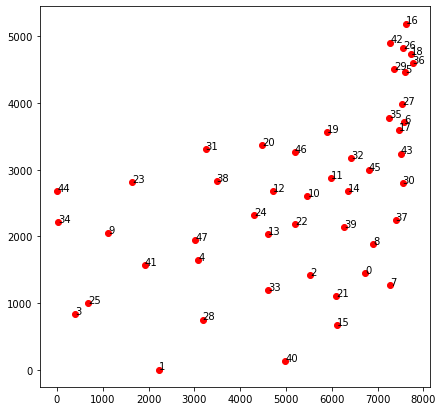

In [21]:
plt.figure(figsize=(7, 7))

#city_index="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range(len(df)):
    plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='red')
    #plt.text(df.iloc[i]['x']+0.5, df.iloc[i]['y']+0.5, f'{city_index[i]}')
    plt.text(df.iloc[i]['x']+0.88, df.iloc[i]['y']+0.88, f'{i}')

plt.show()

In [22]:
class QuboPoly():
    def __init__(self, n=1024):
        self.array=np.zeros((n, n), dtype=int)
        self.constant=0
        self._size=n
    
    def add_term(self, i, j, c):
        if i>=self._size or j>=self._size:
            raise RuntimeError("Wrong index")
        self.array[i][j]+=c
        
    def add_constant(self, c):
        self.constant+=c
        
    def sum(self, p):
        if self._size != p._size:
            raise RuntimeError("Wrong polynomial size")
        self.array+=p.array
        self.constant+=p.constant
        
    def power(self):
        a=np.diag(self.array)
        self.array=np.outer(a, a) + 2*self.constant*np.diag(a) # convert back to NxN
        self.constant**=2
        
    def multiply(self, p):
        a=np.diag(self.array)
        b=np.diag(p.array)
        self.array=np.outer(a, b) + self.constant*np.diag(b) + p.constant*np.diag(a)
        self.constant*=p.constant

##### $ Obj=\sum_{t=0}^{time-1}\sum_{i=0}^{city}\sum_{j=0}^{city}x_{i,t}\cdot x_{j,t+1}\cdot d_{i,j} + \sum_{i=0}^{city}\sum_{j=0}^{city}x_{i,t_{end}}\cdot x_{j,0}\cdot d_{i,j} $ (last terms for calculating Hamiltonian cycle)

In [23]:
def objective_function():
    qubo=QuboPoly(n_point*time_step)
    # Ex. 3 cities iterate 0 1 2-> (0,1) (0,2) (2,0)
    for t in range(time_step):
        for i in range(n_point):
            for j in range(n_point):
                #print(city_index[i], city_index[j], t)
                if t==time_step-1: 
                    qubo.add_term((i*time_step)+t, (j*time_step), d[i][j])  # last terms that the final destination reaches the original node
                else:
                    qubo.add_term((i*time_step)+t, (j*time_step)+t+1, d[i][j])
    #print(qubo.array)
    return qubo

##### $ C_{1}=\sum_{t=0}^{time}(\sum_{i=0}^{city} x_{i, t}-1)^2 $ (one-hot constraint for column)

In [24]:
def build_one_car_each_t(alpha):
    qubo=QuboPoly(n_point*time_step)
    for t in range(time_step-1):  # CHANGED!
        tmp=QuboPoly(n_point*time_step)
        for i in range(n_point):
            #print((i*time_step)+t, t)
            tmp.add_term((i*time_step)+t, (i*time_step)+t, alpha)
        tmp.add_constant(-alpha)
        tmp.power()
        qubo.sum(tmp)
        #print(tmp.array)
    #print(qubo.array)
    return qubo

##### $ C_{2}=\sum_{i=0}^{city}(\sum_{t=0}^{time} x_{i, t}-1)^2 $ (one-hot constraint for row)

In [25]:
def build_car_visit_once(alpha):
    qubo=QuboPoly(n_point*time_step)
    for i in range(n_point):
        tmp=QuboPoly(n_point*time_step)
        for t in range(time_step-1):  # CHANGED!
            #print((i*time_step)+t, t)
            tmp.add_term((i*time_step)+t, (i*time_step)+t, alpha)
        tmp.add_constant(-alpha)
        tmp.power()
        qubo.sum(tmp)
        #print(tmp.array)
    #print(qubo.array)
    return qubo

#### Building $Q$ matrix

In [126]:
from time import monotonic
start_time=monotonic()  # timer

Q=QuboPoly(n_point*time_step)
Obj=objective_function()
C1=build_one_car_each_t(500) # column-alpha
C2=build_car_visit_once(500) # row-alpha
Q.sum(Obj)
Q.sum(C1)
Q.sum(C2)

print(f"Gen. Q time {monotonic() - start_time} seconds")
print("constant =", Q.constant)
#print(Q.array)
print(f"Matrix size: {Q._size} x {Q._size}")

Gen. Q time 9.028577439999935 seconds
constant = 23750000
Matrix size: 2304 x 2304


In [127]:
from collections import defaultdict
Q_dwave=defaultdict(int)

for i in range(Q._size):
    for j in range(Q._size):
        if Q.array[i, j]!=0:
            Q_dwave[(i, j)]=Q.array[i, j]

print("# of terms =", len(Q_dwave))
print("# of total =", Q._size**2)
print(f'Terms = {len(Q_dwave)/(Q._size**2)}%')

# of terms = 320352
# of total = 5308416
Terms = 0.06034794560185185%


### Solve $x^TQx$ via D'Wave QM

In [128]:
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
from dimod import BinaryQuadraticModel

bqm=BinaryQuadraticModel('BINARY')
bqm=BinaryQuadraticModel.from_qubo(Q_dwave)

In [129]:
start_time=monotonic()

bqm_sampler=LeapHybridSampler()
sampleset=bqm_sampler.sample(bqm, label='ATT48-TSP-QUBO1', time_limit=6)
#sampleset=bqm_sampler.sample(bqm, label='ATT48-TSP-QUBO1')

print(f"D-wave time {monotonic() - start_time} seconds")

D-wave time 54.44299496199892 seconds


In [130]:
print(sampleset.info)

{'qpu_access_time': 42741, 'charge_time': 5999835, 'run_time': 5999835, 'problem_id': '0742635b-01b5-479c-9991-dcfbcc0bc8af', 'problem_label': 'ATT48-TSP-QUBO1'}


In [131]:
best_sample=sampleset.first.sample
best_energy=sampleset.first.energy

print("Best Sample:", best_sample)
print("Best Energy:", best_energy)

# map it back to answer
solution=np.zeros(n_point*time_step, dtype=int)
for index, var in enumerate(best_sample):
    solution[index]=int(best_sample[var])

Best Sample: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 1, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 1, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 

In [132]:
#import sys
#np.set_printoptions(threshold=sys.maxsize)
#print(solution.reshape(n_point, time_step))
solution=solution.reshape(n_point, time_step)
print(solution)

[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0

In [133]:
def check_c1():
    for t in range(time_step-1):
        cnt=0
        for i in range(n_point):
            cnt+=solution[i][t]
        if cnt!=1:
            return False
    return True

def check_c2():
    for i in range(n_point):
        cnt=0
        for t in range(time_step-1):
            cnt+=solution[i][t]
        if cnt!=1:
            return False
    return True

In [134]:
routes=[0]*time_step
for index, (key, val) in enumerate(best_sample.items()):
    #print(index, key, val)
    if val > 0.5:
        print(f'x{index} = {val} (city: {int(index/time_step)}, time: {index%time_step})')
        routes[index%time_step]=int(index/time_step)

# append for drawing graph with Hamiltonian cycle by hand
routes.append(routes[0])
print(routes)
print("Number of visited:", len(routes))
print("Number of unique:", len(set(routes)))
print("C1:", check_c1())
print("C2:", check_c2())

x3 = 1 (city: 0, time: 3)
x74 = 1 (city: 1, time: 26)
x104 = 1 (city: 2, time: 8)
x169 = 1 (city: 3, time: 25)
x220 = 1 (city: 4, time: 28)
x283 = 1 (city: 5, time: 43)
x300 = 1 (city: 6, time: 12)
x341 = 1 (city: 7, time: 5)
x394 = 1 (city: 8, time: 10)
x452 = 1 (city: 9, time: 20)
x516 = 1 (city: 10, time: 36)
x563 = 1 (city: 11, time: 35)
x608 = 1 (city: 12, time: 32)
x657 = 1 (city: 13, time: 33)
x709 = 1 (city: 14, time: 37)
x726 = 1 (city: 15, time: 6)
x808 = 1 (city: 16, time: 40)
x816 = 1 (city: 17, time: 0)
x908 = 1 (city: 18, time: 44)
x927 = 1 (city: 19, time: 15)
x990 = 1 (city: 20, time: 30)
x1015 = 1 (city: 21, time: 7)
x1090 = 1 (city: 22, time: 34)
x1123 = 1 (city: 23, time: 19)
x1183 = 1 (city: 24, time: 31)
x1224 = 1 (city: 25, time: 24)
x1290 = 1 (city: 26, time: 42)
x1309 = 1 (city: 27, time: 13)
x1371 = 1 (city: 28, time: 27)
x1431 = 1 (city: 29, time: 39)
x1451 = 1 (city: 30, time: 11)
x1506 = 1 (city: 31, time: 18)
x1574 = 1 (city: 32, time: 38)
x1593 = 1 (city: 

#### Visualization

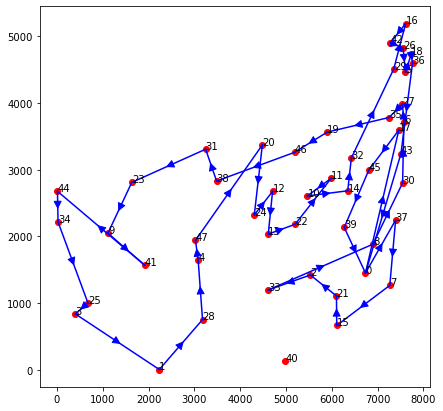

Total cost: 47220.203079017534


In [135]:
plt.figure(figsize=(7, 7))

for i in range(len(df)):
    plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='red')
    plt.text(df.iloc[i]['x']+0.88, df.iloc[i]['y']+0.88, f'{i}')

for i in range(len(routes)-1):
    #plt.arrow(df.iloc[routes[i]]['x'], df.iloc[routes[i]]['y'], df.iloc[routes[i+1]]['x'] - df.iloc[routes[i]]['x'], df.iloc[routes[i+1]]['y'] - df.iloc[routes[i]]['y'], 
    #head_width=2, head_length=3, fc='blue', ec='blue')
    x1, y1=df.iloc[routes[i]]['x'], df.iloc[routes[i]]['y']
    x2, y2=df.iloc[routes[i+1]]['x'], df.iloc[routes[i+1]]['y']
    plt.plot([x1, x2], [y1, y2], c='blue')

    mid_x=(x1+x2)/2
    mid_y=(y1+y2)/2
    dx=(x2-x1)*0.05  # Offset along x-direction
    dy=(y2-y1)*0.05  # Offset along y-direction
    
    #plt.annotate('', xy=(mid_x + dx, mid_y + dy), xytext=(mid_x, mid_y), arrowprops=dict(arrowstyle='->', color='blue'))
    plt.annotate('', xy=(mid_x + dx, mid_y + dy), xytext=(mid_x, mid_y),
                 arrowprops=dict(arrowstyle='simple, tail_width=0.5, head_width=0.69, head_length=0.69', color='blue'))
        
plt.show()

cost=0
for i in range(len(routes)-1):
    cost+=d[routes[i]][routes[i+1]]
print("Total cost:", cost)

Optimum solution for ATT48

In [136]:
opt_seq=[0, 7, 37, 30, 43, 17, 6, 27, 5, 36, 18, 26, 16, 42, 29, 35, 45, 32, 19, 46, 20, 31, 38, 47, 4, 41, 23, 9, 44, 34, 3, 25, 1, 28, 33, 40, 15, 21, 2, 22, 13, 24, 12, 10, 11, 14, 39, 8, 0]
opt_cost=0
for i in range(len(opt_seq)-1):
    opt_cost+=d[opt_seq[i]][opt_seq[i+1]]
print("OPTIMUM COST:", opt_cost)
#routes=opt_seq

OPTIMUM COST: 33523.70850743559
